## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
import models_segmentation

from pathlib import Path
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from SegmentationDataset import SegmentationDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


### Define utils

In [17]:
def prepare_model(chkpt_dir, arch='mae_vit_large_patch_16_gray'):
    # build model
    model = getattr(models_segmentation, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    checkpoint_model = checkpoint['model']
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    return model

def display_confusion_mat(conf_mat: np.ndarray, class_labels, title='', normalize=True):
    if normalize:
        # Normalize the confusion matrix if specified
        row_sums = conf_mat.sum(axis=1, keepdims=True)
        conf_mat = conf_mat / row_sums.astype(float)

    # Set up the figure
    plt.figure()

    # Create a heatmap using seaborn
    sns.heatmap(conf_mat, annot=True, fmt='.2f' if normalize else 'd', cmap='Reds',
                xticklabels=class_labels, yticklabels=class_labels)

    # Configure plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{title} Confusion Matrix')
    plt.savefig(f"{title}.png", dpi=800)
    # Display the plot
    plt.show()

### Load a pre-trained MAE model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
chkpt_dir = Path('../checkpoints/checkpoint-spect-segm.pth')
model = prepare_model(chkpt_dir, arch='seg_vit_large_patch16')
chkpt_dir = Path('../checkpoints/checkpoint-audio-spect-segm.pth')
model_audio = prepare_model(chkpt_dir, arch='seg_vit_base_patch16')
model = model.to(device)
model_audio = model_audio.to(device)
model.eval()
model_audio.eval()

<All keys matched successfully>
<All keys matched successfully>


SegmentationViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dr

### Load dataset

In [4]:
dataset_test = SegmentationDataset(dataset_dir=Path('../../QoherentLnC_V2/SegmentationData/Test/LTE_NR'))

### Run VIT on one image

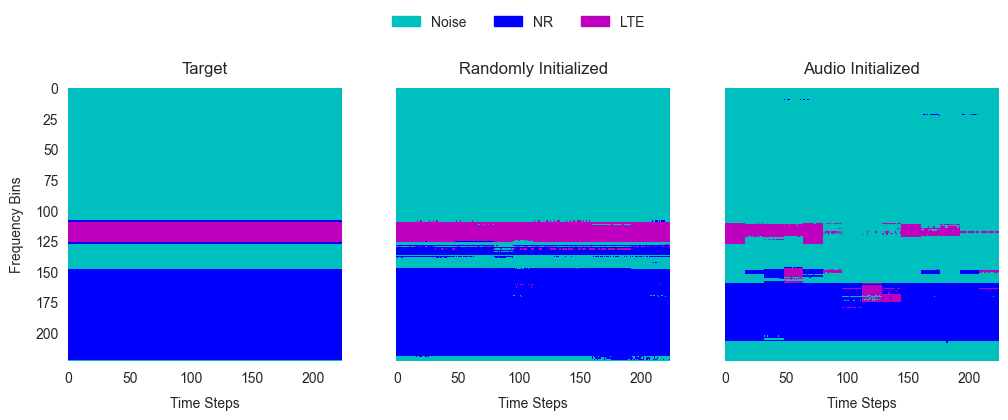

In [41]:
sample, target = dataset_test[np.random.randint(0, len(dataset_test))]
sample = sample.unsqueeze(0).to(device)
output = model(sample).squeeze(0).argmax(dim=0).detach().cpu().numpy()
output_audio = model_audio(sample).squeeze(0).argmax(dim=0).detach().cpu().numpy()
target = target.squeeze(0).detach().cpu().numpy()

colors = ['c', 'b', 'm']
class_list = ['Noise', 'NR', 'LTE']
legend_patches = [mpatches.Patch(color=color, label=class_list[i]) for i, color in enumerate(colors)]

cmap = ListedColormap(colors)
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_figwidth(12)
fig.set_figheight(4)

axs[0].imshow(target, cmap=cmap, interpolation='none')
axs[1].imshow(output, cmap=cmap, interpolation='none')
axs[2].imshow(output_audio, cmap=cmap, interpolation='none')

# Titles and labels
axs[0].set_title('Target', fontsize=12, pad=10)
axs[1].set_title('Randomly Initialized', fontsize=12, pad=10)
axs[2].set_title('Audio Initialized', fontsize=12, pad=10)
axs[0].set_xlabel('Time Steps', fontsize=10, labelpad=8)
axs[1].set_xlabel('Time Steps', fontsize=10, labelpad=8)
axs[2].set_xlabel('Time Steps', fontsize=10, labelpad=8)
axs[0].set_ylabel('Frequency Bins', fontsize=10, labelpad=8)

# Turn off grid and remove spines
for ax in axs:
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Legend
fig.legend(handles=legend_patches, ncol=3, loc='upper center', fontsize=10, bbox_to_anchor=(0.5, 1.05), frameon=False)

plt.savefig('fig_spectrogram_segmentation.png', bbox_inches='tight', dpi=300)
plt.show()


### Confusion Matrices

Plotting: 100%|██████████| 94/94 [01:02<00:00,  1.50batch/s]


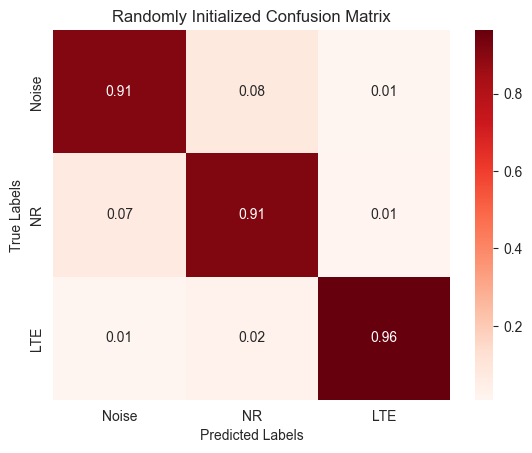

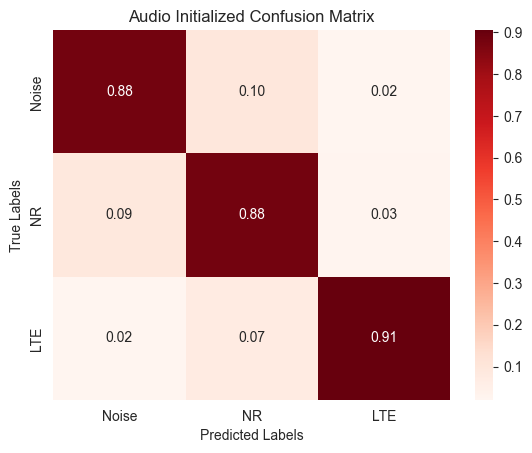

In [16]:
title_list = ['Randomly Initialized', 'Audio Initialized']
test_loader = DataLoader(dataset_test, batch_size=16)

conf_mat = np.zeros((3, 3))
conf_mat_audio = np.zeros((3, 3))
with torch.no_grad():
    with tqdm(test_loader, desc='Plotting', unit='batch') as pbar:
        for samples, targets in pbar:
            samples = samples.to(device)
            outputs = model(samples)
            outputs_audio = model_audio(samples)
            outputs = outputs.permute(0, 2, 3, 1).reshape(-1, outputs.shape[1]).argmax(dim=-1).detach().cpu().numpy()
            outputs_audio = outputs_audio.permute(0, 2, 3, 1).reshape(-1, outputs_audio.shape[1]).argmax(dim=-1).detach().cpu().numpy()
            targets = targets.view(-1).detach().cpu().numpy()
            conf_mat += confusion_matrix(outputs, targets)
            conf_mat_audio += confusion_matrix(outputs_audio, targets)
            
display_confusion_mat(conf_mat, ['Noise', 'NR', 'LTE'], normalize=True, title=title_list[0])
display_confusion_mat(conf_mat_audio, ['Noise', 'NR', 'LTE'], normalize=True, title=title_list[1])

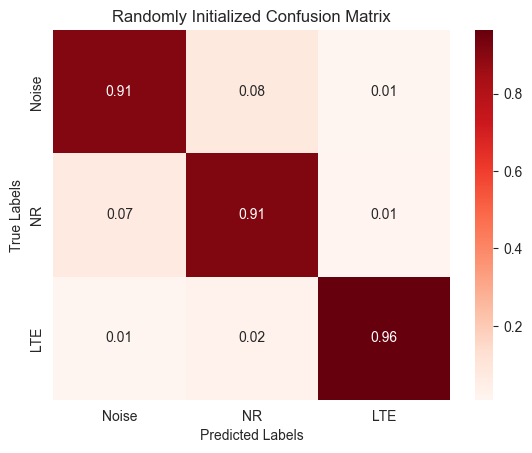

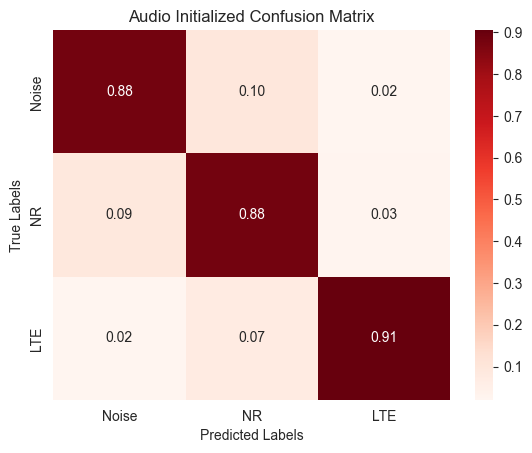

In [18]:
display_confusion_mat(conf_mat, ['Noise', 'NR', 'LTE'], normalize=True, title=title_list[0])
display_confusion_mat(conf_mat_audio, ['Noise', 'NR', 'LTE'], normalize=True, title=title_list[1])